In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def build_gan(latent_dim, img_shape):
    def build_generator():
        model = models.Sequential()
        model.add(layers.Dense(16 * 16 * 128, input_dim=latent_dim, activation='relu'))
        model.add(layers.Reshape((16, 16, 128)))
        model.add(layers.UpSampling2D())  # Increase spatial resolution
        model.add(layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.UpSampling2D())  # Increase spatial resolution
        model.add(layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.UpSampling2D())  # Increase spatial resolution
        model.add(layers.Conv2D(16, kernel_size=3, padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.UpSampling2D())
        model.add(layers.Conv2D(3, kernel_size=3, padding='same', activation='tanh'))  # Output RGB images
        return model 

    def build_discriminator():
        model = models.Sequential()
        # Expect input images of shape (256, 256, 3)
        model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dropout(0.3))
        model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dropout(0.3))
        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))
        return model

    def build_gan(generator, discriminator):
        model = models.Sequential()
        model.add(generator)
        model.add(discriminator)
        return model

    generator = build_generator()
    discriminator = build_discriminator()

    # Compile the discriminator
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Compile the GAN
    gan = build_gan(generator, discriminator)
    gan.compile(optimizer='adam', loss='binary_crossentropy')

    return generator, discriminator, gan

def load_images_from_folder(folder_path, target_size=(256, 256)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        try:
            img = load_img(img_path, target_size=target_size)
            img = img_to_array(img)
            img = ((img / 127.5) - 1)  # Normalize to [-1, 1]
            images.append(img)
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return np.array(images)

def create_dataset_from_images(images, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, img_shape, dataset):
    real_label = 1
    fake_label = 0

    for epoch in range(epochs):
        for real_images in dataset:
            batch_size = real_images.shape[0]

            # Generate fake images
            noise = tf.random.normal([batch_size, latent_dim])
            fake_images = generator(noise, training=False)

            # Check shapes
            print(f"Real images shape: {real_images.shape}")
            print(f"Fake images shape: {fake_images.shape}")

            # Train the discriminator
            with tf.GradientTape() as tape:
                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(fake_images, training=True)
                
                d_loss_real = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
                d_loss_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
                d_loss = d_loss_real + d_loss_fake
                
            grads = tape.gradient(d_loss, discriminator.trainable_variables)
            discriminator.optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

            # Train the generator
            noise = tf.random.normal([batch_size, latent_dim])
            with tf.GradientTape() as tape:
                fake_images = generator(noise, training=True)
                fake_output = discriminator(fake_images, training=False)
                g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
            grads = tape.gradient(g_loss, generator.trainable_variables)
            gan.optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        print(f"Epoch {epoch + 1}/{epochs}, D Loss: {d_loss.numpy()}, G Loss: {g_loss.numpy()}")

# Example usage
latent_dim = 100
img_shape = (256, 256, 3)  # For RGB images of size 256x256
latent= 100
batch_size = 16
epochs = 100  # Increase for better results
image_dir = 'd'  # Update this to the path of your image folder

# Load images
images = load_images_from_folder(image_dir, target_size=(256, 256))

# Create a dataset
dataset = create_dataset_from_images(images, batch_size)

# Build and train the GAN
generator, discriminator, gan = build_gan(latent_dim, img_shape)
train_gan(generator, discriminator, gan, epochs, batch_size, latent_dim, img_shape, dataset)


c:\Users\MY\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\MY\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\MY\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Real images shape: (7, 256, 256, 3)
Fake images shape: (7, 256, 256, 3)
Epoch 1/100, D Loss: [1.402375  1.4246035 1.3698986 1.4007814 1.3788354 1.3166265 1.3864362], G Loss: [5.5336664e-06 2.3682826e-06 2.0449118e-06 2.1817311e-06 2.4592796e-06
 3.0977128e-06 3.4618733e-06]
Real images shape: (7, 256, 256, 3)
Fake images shape: (7, 256, 256, 3)
Epoch 2/100, D Loss: [1.0557002 1.1279647 1.0987521 1.0862582 1.0349083 1.0750173 1.0817698], G Loss: [9.4084953e-08 3.2888881e-08 9.0922763e-09 2.4871150e-07 7.2046928e-09
 1.6820600e-08 1.9804262e-10]
Real images shape: (7, 256, 256, 3)
Fake images shape: (7, 256, 256, 3)
Epoch 3/100, D Loss: [0.5847363  0.6249446  0.59787077 0.553062   0.56050944 0.63788044
 0.532305  ], G Loss: [3.0584452e-11 4.7500504e-11 1.1517964e-08 1.1712641e-10 2.6625618e-10
 7.5785449e-09 4.9771987e-09]
Real images shape: (7, 256, 256, 3)
Fake images shape: (7, 256, 256, 3)
Epoch 4/100, D Loss: [0.39784613 0.28698397 0.24446478 0.397827   0.23726405 0.21013698
 0.2557

In [2]:
generator.save('f.keras')

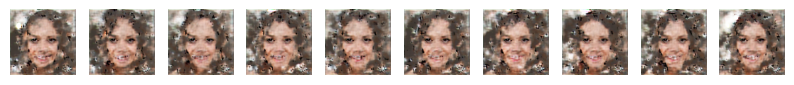

In [3]:
import matplotlib.pyplot as plt
def generate_and_save_images(generator, latent_dim, num_images=10, output_dir='generated_images'):
    # Generate random noise
    noise = tf.random.normal([num_images, latent_dim])
    # Generate fake images
    generated_images = generator(noise, training=False)
    # Rescale images from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1) / 2.0
    # Plot and save images
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        # Save individual images
        #plt.imsave(os.path.join(output_dir, f'image_{i + 1}.png'), generated_images[i])
    
    plt.show()
    
generate_and_save_images(generator, latent_dim=100, num_images=10, output_dir='generated_images')

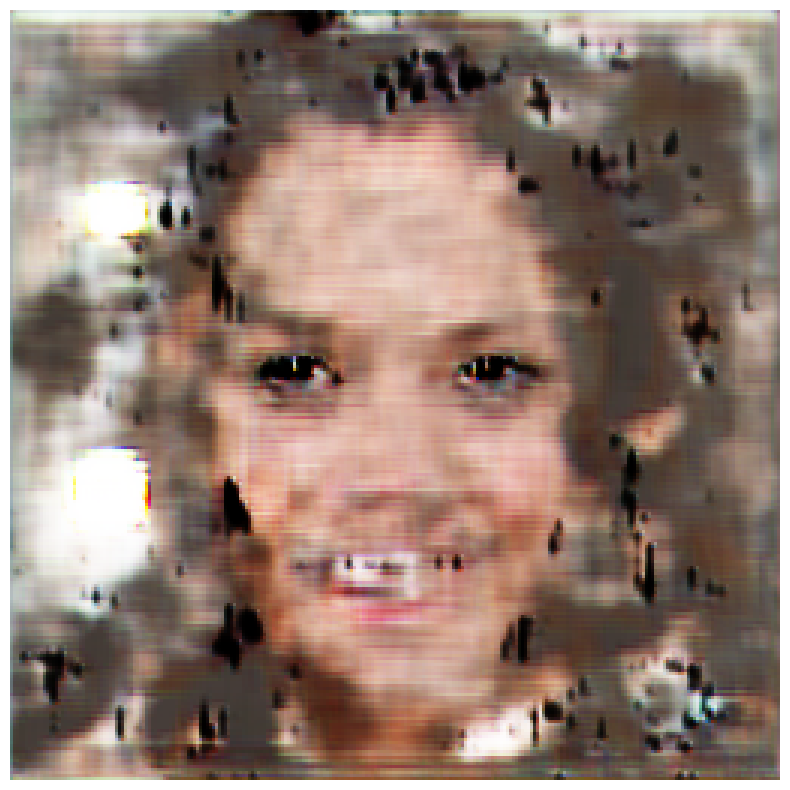

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
model = tf.keras.models.load_model('f.keras')
def generate_and_save_images(generator, latent_dim, num_images=1, output_dir='generated_images'):
    # Generate random noise
    noise = tf.random.normal([num_images, latent_dim])
    # Generate fake images
    generated_images = generator(noise, training=False)
    # Rescale images from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1) / 2.0
    # Plot and save images
    plt.figure(figsize=(10, 10))
    for i in range(1):
        #plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        # Save individual images
        #plt.imsave(os.path.join(output_dir, f'image_{i + 1}.png'), generated_images[i])
    
    plt.show()
    
generate_and_save_images(generator=model, latent_dim=100, num_images=10, output_dir='generated_images')